In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords

In [11]:
df = pd.read_csv('../../datasets/WELFake.csv')
print(df.shape)
df.dropna(subset=['text'], inplace=True)
print(df.shape)

(71537, 6)
(71537, 6)


In [12]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [13]:
df.sample(5)

,Unnamed: 0,title,text,label,language,category
51156,51556,Mainstream Media Spreads Huge Lie GOP Official...,The usual mainstream media suspects are at it ...,1,en,MEDIA
27901,28097,HOLY CONTRACEPTION! Pope Francis Tells Latin A...,"And the hits just keep on coming, as the Pope ...",1,en,RELIGION
64783,65322,May nudges UK towards a friendly EU divorce,Prime Minister Theresa May s divorce deal with...,0,en,WORLDPOST
38607,38896,Obama family explores 'Big Room' cavern on nat...,U.S. President Barack Obama and his family esc...,0,en,POLITICS
65146,65688,Judge refuses to remove block on Trump sanctua...,A U.S. judge on Thursday refused to revisit a ...,0,en,POLITICS


In [14]:
#keep just the en text
df = df[df["language"] == "en"]
df.shape

(70175, 6)

In [15]:
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
# def format_for_fasttext(row):
#     # Convertește eticheta în formatul FastText (de ex.: __label__0 sau __label__1)
#     return f"__label__{row['label']} {row['clean_text']}"

# df['fasttext_format'] = df.apply(format_for_fasttext, axis=1)
# df['fasttext_format'].to_csv('training.txt', index=False, header=False, sep='\n')


In [16]:
import fasttext

# model_supervised = fasttext.train_supervised(
#     input='training.txt', 
#     lr=0.01,          # rata de învățare; ajustează după necesitate
#     epoch=50,         # numărul de epoci; documentul menționează aproximativ 50 de epoci
#     wordNgrams=2,     # folosirea bi-gramelor poate îmbunătăți performanța
#     verbose=2
# )

# model_supervised.save_model("fasttext_supervised_model.bin")

model_supervised = fasttext.load_model("fasttext_supervised_model.bin")


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [18]:
def tokenize(text):
    return text.split()

class FastTextDataset(Dataset):
    def __init__(self, texts, labels, ft_model, max_len=100):
        """
        texts: lista de texte preprocesate (string-uri)
        labels: lista etichetelor (de ex. 0 sau 1)
        ft_model: modelul FastText supervised antrenat (model_supervised)
        max_len: lungimea maximă a secvenței (se aplică padding sau truncare)
        """
        self.texts = texts
        self.labels = labels
        self.ft_model = ft_model
        self.max_len = max_len
        self.embedding_dim = ft_model.get_dimension()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = tokenize(text)
        embeddings = []
        for token in tokens:
            vec = self.ft_model.get_word_vector(token)  
            embeddings.append(vec)
        if len(embeddings) < self.max_len:
            pad_length = self.max_len - len(embeddings)
            pad = [np.zeros(self.embedding_dim)] * pad_length
            embeddings.extend(pad)
        else:
            embeddings = embeddings[:self.max_len]
        embeddings = torch.tensor(embeddings, dtype=torch.float)  
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return embeddings, label

In [19]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_sizes, lstm_hidden_dim, lstm_layers, num_classes, dropout=0.5):
        super(CNN_LSTM_Model, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size=num_filters * len(filter_sizes),
                            hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(lstm_hidden_dim * 2, num_classes)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  
        conv_outs = [torch.relu(conv(x)) for conv in self.convs]  
        pooled = [torch.max(conv_out, dim=2)[0] for conv_out in conv_outs]  
        cnn_features = torch.cat(pooled, dim=1)  
        cnn_features = cnn_features.unsqueeze(1)
        lstm_out, (hn, cn) = self.lstm(cnn_features)  
        lstm_out = lstm_out.squeeze(1)  
        out = self.fc(self.dropout(lstm_out))
        return out

In [20]:
texts = df['clean_text'].tolist() 
labels = df['label'].tolist()       

max_len = 500  
embedding_dim = model_supervised.get_dimension()
batch_size = 128
pin_memory = True
num_workers = 4


In [21]:
dataset = FastTextDataset(texts, labels, ft_model=model_supervised, max_len=max_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=pin_memory)

In [22]:
model = CNN_LSTM_Model(
    embedding_dim=embedding_dim,
    num_filters=128,
    filter_sizes=[3, 4, 5],
    lstm_hidden_dim=256,
    lstm_layers=2,
    num_classes=2,
    dropout=0.3
)

In [23]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DataParallel(
  (module): CNN_LSTM_Model(
    (convs): ModuleList(
      (0): Conv1d(100, 128, kernel_size=(3,), stride=(1,))
      (1): Conv1d(100, 128, kernel_size=(4,), stride=(1,))
      (2): Conv1d(100, 128, kernel_size=(5,), stride=(1,))
    )
    (dropout): Dropout(p=0.3, inplace=False)
    (lstm): LSTM(384, 256, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch

Epoch 1/5, Train Loss: 0.2392, Train Acc: 0.9002 | Val Loss: 0.2349, Val Acc: 0.9016


/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch

Epoch 2/5, Train Loss: 0.2362, Train Acc: 0.9014 | Val Loss: 0.2350, Val Acc: 0.9017


/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch

Epoch 3/5, Train Loss: 0.2353, Train Acc: 0.9023 | Val Loss: 0.2328, Val Acc: 0.9032


/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch

Epoch 4/5, Train Loss: 0.2322, Train Acc: 0.9036 | Val Loss: 0.2331, Val Acc: 0.9049


/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_1677347/2002856107.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch

Epoch 5/5, Train Loss: 0.2323, Train Acc: 0.9033 | Val Loss: 0.2345, Val Acc: 0.9017
Curba de învățare salvată ca 'learning_curve.png'!


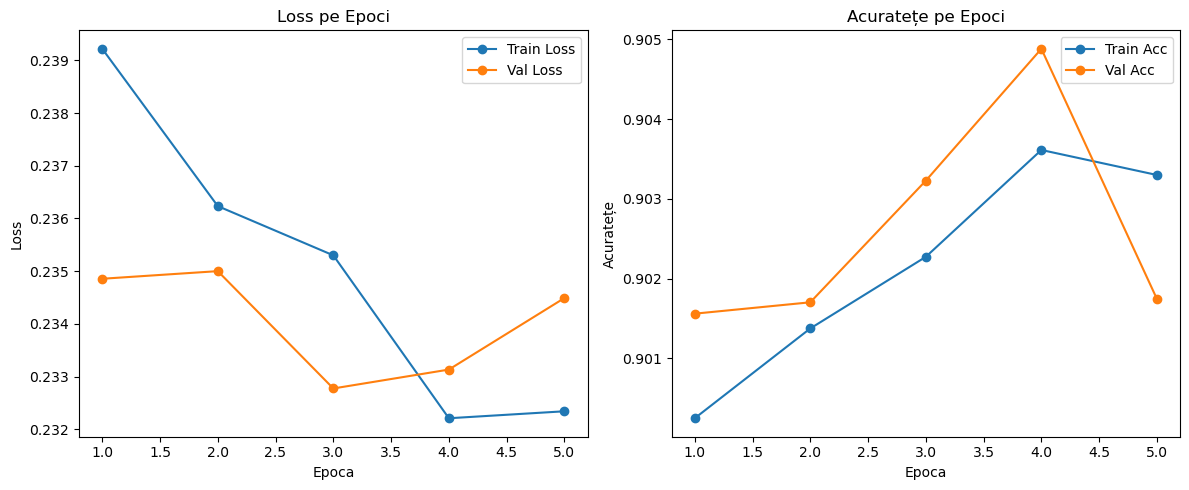

In [28]:
num_epochs = 5
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Partea de antrenament
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_inputs, batch_labels in dataloader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)

    epoch_train_loss = running_loss / len(dataset)
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Evaluare (folosind același dataloader, pentru demonstrație)
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_inputs, batch_labels in dataloader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            val_running_loss += loss.item() * batch_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == batch_labels).sum().item()
            val_total += batch_labels.size(0)

    epoch_val_loss = val_running_loss / len(dataset)
    epoch_val_acc = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")


# Salvare model
torch.save(model.state_dict(), "fasttext_cnn_lstm.pth")
#print("Antrenament finalizat și model salvat!")

# Creare și salvare curba de învățare (train și validare)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, marker='o', label="Val Loss")
plt.title('Loss pe Epoci')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label="Train Acc")
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o', label="Val Acc")
plt.title('Acuratețe pe Epoci')
plt.xlabel('Epoca')
plt.ylabel('Acuratețe')
plt.legend()

plt.tight_layout()
plt.savefig("learning_curve.png")
print("Curba de învățare salvată ca 'learning_curve.png'!")